# DL in NLP

## Task 2: Classifying TED talks

Sergei Volodin, senior undergraduate student at MIPT

In [1]:
%matplotlib inline
import tensorflow as tf
import json
import numpy as np
import pandas as pd
import collections
from __future__ import print_function
import re
import random
import math
from sklearn.manifold import TSNE
from matplotlib import pylab
from transliterate import translit
from six.moves import range
import sklearn.metrics
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from tqdm import tqdm

In [2]:
def print_unicode(ent):
    print(repr(ent).decode("unicode-escape"))

In [3]:
filename = 'ted_ru-20160408.json'
data_test = json.loads(open(filename + '.test', 'r').read(), 'unicode-escape')
data_train = json.loads(open(filename + '.train', 'r').read(), 'unicode-escape')

In [4]:
class_to_vector = {
    1: [1,0,0,0,0,0,0,0],
    2: [0,1,0,0,0,0,0,0],
    3: [0,0,1,0,0,0,0,0],
    4: [0,0,0,1,0,0,0,0],
    5: [0,0,0,0,1,0,0,0],
    6: [0,0,0,0,0,1,0,0],
    7: [0,0,0,0,0,0,1,0],
    8: [0,0,0,0,0,0,0,1]
}

Plan:

1. Removing non-letters
2. Obtaining words, training word2vec CBOW model
3. Running RNN on document
4. Classifying based on final hidden state

In [18]:
all_train_text = ' '.join(map(lambda x : x['content'], data_train))

In [19]:
words_regex = re.compile(ur'[^а-яА-ЯёЁa-zA-Z]')
def str_to_words(s):
    return(words_regex.sub(' ', s).lower().split())

In [20]:
train_words = str_to_words(all_train_text)

In [21]:
vocabulary_size = 50000

In [22]:
def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(train_words, vocabulary_size)
print_unicode(count[:5])
print_unicode(data[:10])

[['UNK', 139493], (u'и', 92090), (u'в', 83510), (u'что', 57304), (u'я', 47139)]
[4, 49, 42333, 12866, 7686, 21, 4461, 740, 105, 31181]


In [23]:
data_index = 0

def to_range(n):
    return(n % len(data))

# CBOW model
def generate_batch(batch_size, context_size):
    global data_index
  
    data_index = to_range(data_index)
    
    batch = np.ndarray(shape=(batch_size, context_size * 2), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        labels[i] = data[data_index]
        for j in range(0, context_size):
            batch[i][2 * j] = data[to_range(data_index - (j + 1))]
            batch[i][2 * j + 1] = data[to_range(data_index + (j + 1))]
        data_index = to_range(data_index + 1)
        
    return batch, labels

In [6]:
batch_size = 128
embedding_size = 256
context_size = 4
num_sampled = 64
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, context_size * 2], name = "train_dataset")
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1], name = "train_labels")
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name = "embeddings")
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)), name = "SM_weights")
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]), name = "SM_biases")
    
    embed = tf.reduce_mean(tf.nn.embedding_lookup(embeddings, train_dataset), [1], name = "emb_result")
    loss = tf.reduce_mean(
      tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size), name = "loss")

  
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    tf.summary.scalar("Embedding_loss", loss)
    summary_emb = tf.summary.merge_all()

In [7]:
logs_path = '/home/etoestja/tensorboard/05'
writer = tf.summary.FileWriter(logs_path, graph=graph)

In [14]:
epochs = 30000
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for epoch in tqdm(range(epochs)):
        batch_data, batch_labels = generate_batch(batch_size, context_size)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l, summary = session.run([optimizer, loss, summary_emb], feed_dict = feed_dict)
        writer.add_summary(summary, epoch)
    final_embeddings = normalized_embeddings.eval()

100%|██████████| 30000/30000 [08:41<00:00, 57.48it/s]


In [8]:
emb_fn = "emb1.pkl"
#pickle.dump(final_embeddings, open(emb_fn, 'w'))
final_embeddings = pickle.load(open(emb_fn, 'r'))

In [9]:
pad_word = vocabulary_size
max_words = 5600

In [14]:
def str_to_idx(s):
    words = str_to_words(s)
    res = []
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
        res.append(index)
    return(res)
def get_Y(data):
    classes = map(lambda x: x['class'], data_train)
    res = map(lambda x: class_to_vector[x], classes)
    res = np.array(res)#.reshape(-1, 3, 1)
    return(res)
def get_X(data):
    X = map(lambda x : str_to_idx(x['content']), data)
    L = map(lambda x : len(x), X)
    X = map(lambda x : x + [pad_word] * (max_words - len(x)), X)
    return np.array(X), np.array(L)

In [24]:
X, L = get_X(data_train)

In [25]:
Y = get_Y(data_train)

In [26]:
c_graph = tf.Graph()
with c_graph.as_default(), tf.device('/cpu:0'):
    text_input = tf.placeholder(tf.int32, shape=[None, None])
    text_length = tf.placeholder(tf.float32, shape=[None])
    ans_input = tf.placeholder(tf.float32, shape=[None, 8])
    
    changeable_embeddings = tf.Variable(final_embeddings, name = "embeddings", trainable = False, dtype = tf.float32)
    non_changeable_embeddings = tf.Variable(1. * np.zeros((1, embedding_size)), trainable = False, dtype = tf.float32)
    embeddings = tf.concat([changeable_embeddings, non_changeable_embeddings], 0)
    
    text_embeddings = tf.reshape(tf.nn.embedding_lookup(embeddings, text_input), [-1, max_words, embedding_size, 1])
    
    #text_mean = tf.reduce_sum(text_embeddings, [1]) / tf.reshape(text_length, [-1, 1])
    
    num_filters = 64
    pooled_outputs = []
    filter_sizes = [2, 3, 5]
    for filter_size in filter_sizes:
        with tf.name_scope("conv-maxpool-%s" % filter_size):
            # Convolution Layer
            filter_shape = [filter_size, embedding_size, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
            #b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
            conv = tf.nn.conv2d(
                text_embeddings,
                W,
                strides=[1, 1, 1, 1],
                padding="VALID",
                name="conv")
            # Apply nonlinearity
            #h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
            h = tf.nn.relu(conv, name="relu")
            # Max-pooling over the outputs
            pooled = tf.nn.max_pool(
                h,
                ksize=[1, max_words - filter_size + 1, 1, 1],
                strides=[1, 1, 1, 1],
                padding='VALID',
                name="pool")
            pooled_outputs.append(pooled)
 
    # Combine all the pooled features
    num_filters_total = num_filters * len(filter_sizes)
    h_pool = tf.concat(pooled_outputs, 3)
    h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])
    
    #h_drop = tf.nn.dropout(h_pool_flat, 0.5)
    
    #dense1 = tf.layers.dense(inputs = h_drop, units = 20, activation=tf.nn.relu)
    
    #dense1d = tf.nn.dropout(h_drop, 0.9)
    
    #dense1 = tf.layers.dense(inputs = h_drop, units = 10, activation=tf.nn.relu)
    
    dense = tf.layers.dense(inputs = h_pool_flat, units = 8, activation=tf.nn.relu)
   
    # hinge loss
    #c_loss = tf.reduce_mean(tf.square(1 - tf.multiply(ans_input, dense)))
    
    # square loss
    #c_loss =  tf.reduce_mean(tf.squared_difference(ans_input, dense))
    c_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = ans_input, logits = dense))
    
    accuracy = tf.reduce_mean(tf.contrib.metrics.accuracy(tf.to_int32(ans_input), tf.to_int32(tf.sign(dense))))
    
    c_optimizer = tf.train.AdagradOptimizer(0.05).minimize(c_loss)
    
    tf.summary.scalar("Classification_loss", c_loss)
    tf.summary.scalar("Classification_accuracy", accuracy)
    c_summary = tf.summary.merge_all()
    
    c_initializer = tf.global_variables_initializer()
    c_writer = tf.summary.FileWriter(logs_path, graph)

In [27]:
c_sess = tf.Session(graph=c_graph)
c_sess.run(c_initializer)
rolling_epoch = 0

In [66]:
epochs = 500
c_batch_size = 32
for epoch in range(epochs):
    idx = random.sample(range(len(X)), c_batch_size)
    feed_dict = {text_input: X[idx], ans_input: Y[idx], text_length: L[idx]}
    _, l, summary, a = c_sess.run([c_optimizer, c_loss, c_summary, accuracy], feed_dict = feed_dict)
    c_writer.add_summary(summary, rolling_epoch)
    rolling_epoch += 1
    print(epoch, l, a)

0 0.563634 0.777344
1 0.628097 0.789062
2 0.232908 0.84375
3 0.439468 0.8125
4 0.0881139 0.875
5 0.471738 0.816406
6 0.368548 0.84375
7 0.31883 0.851562
8 0.422453 0.839844
9 0.269832 0.839844
10 0.423325 0.8125
11 0.299608 0.8125
12 0.358718 0.828125
13 0.288745 0.824219
14 0.708879 0.785156
15 0.380335 0.816406
16 0.484235 0.828125
17 0.233443 0.835938
18 0.207622 0.886719
19 0.445012 0.808594
20 0.302534 0.84375
21 0.30127 0.835938
22 0.292309 0.820312
23 0.514201 0.761719
24 0.238146 0.835938
25 0.457 0.78125
26 0.302762 0.8125
27 0.157815 0.832031
28 0.360418 0.796875
29 0.167405 0.828125
30 0.348414 0.824219
31 0.16942 0.832031
32 0.496686 0.808594
33 0.353101 0.828125
34 0.224341 0.839844
35 0.364228 0.785156
36 0.454011 0.761719
37 0.150661 0.847656
38 0.307751 0.804688
39 0.301465 0.832031
40 0.211212 0.824219
41 0.212786 0.832031
42 0.351624 0.835938
43 0.289842 0.828125
44 0.280416 0.839844
45 0.0865833 0.839844
46 0.28643 0.792969
47 0.212156 0.863281
48 0.34791 0.824219
49

383 0.297745 0.871094
384 0.405979 0.832031
385 0.0737784 0.90625
386 0.348148 0.839844
387 0.412304 0.816406
388 0.461705 0.824219
389 0.211838 0.859375
390 0.342364 0.835938
391 0.326682 0.847656
392 0.349079 0.835938
393 0.340089 0.839844
394 0.553319 0.796875
395 0.157939 0.882812
396 0.284654 0.832031
397 0.138264 0.867188
398 0.212964 0.871094
399 0.0773067 0.878906
400 0.2013 0.816406
401 0.326212 0.824219
402 0.344634 0.820312
403 0.291773 0.808594
404 0.133777 0.851562
405 0.431263 0.785156
406 0.271472 0.839844
407 0.335749 0.816406
408 0.270543 0.835938
409 0.272035 0.84375
410 0.266453 0.84375
411 0.271927 0.839844
412 0.20359 0.855469
413 0.20556 0.851562
414 0.409228 0.789062
415 0.235429 0.835938
416 0.128093 0.875
417 0.402041 0.804688
418 0.333893 0.824219
419 0.346096 0.824219
420 0.413944 0.820312
421 0.201239 0.859375
422 0.256159 0.84375
423 0.288735 0.839844
424 0.455503 0.839844
425 0.264085 0.867188
426 0.26944 0.863281
427 0.221598 0.855469
428 0.201695 0.85937

In [74]:
#c_sess.close()

In [29]:
c_sess.run(embeddings, feed_dict = {text_input: X[1:10], ans_input: Y[1:10], text_length: L[1:10]})

array([[-0.01385682, -0.01554438, -0.03142336, ...,  0.06008703,
         0.09011126,  0.11042666],
       [ 0.01877063, -0.01414546,  0.01937573, ..., -0.00056613,
         0.01501634,  0.11077736],
       [ 0.02270121,  0.04274043, -0.10701362, ..., -0.0600381 ,
        -0.0524005 , -0.07970373],
       ..., 
       [ 0.09654613, -0.08093843,  0.01539285, ...,  0.09275189,
        -0.08887106, -0.10402228],
       [-0.05485174,  0.0105952 , -0.08756531, ...,  0.04529791,
        -0.03413794,  0.05771342],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [43]:
np.linalg.norm(c_sess.run(embeddings)[:vocabulary_size]-final_embeddings)

0.0

In [21]:
test_idx = random.sample(range(len(X)), 200)

In [25]:
Yp = predict_proba(X, L, test_idx)
def plot_roc(Yt, Yp):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yt, Yp)
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/home/etoestja/venv/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


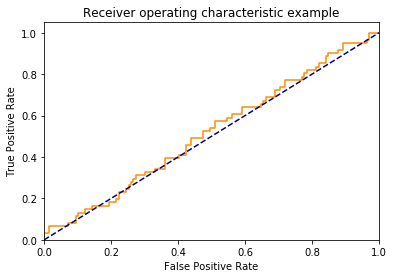

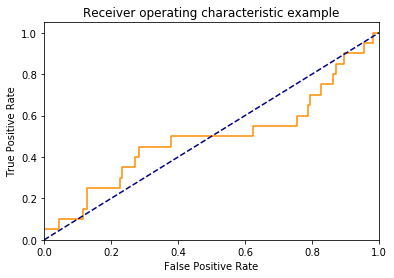

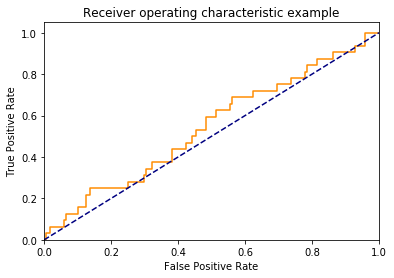

In [26]:
for i in range(Yp.shape[1]):
    plot_roc(Y[test_idx, i], Yp[:, i])

# Test

In [32]:
X_test, L_test = get_X(data_test)

In [33]:
def predict_proba_small(X, L, idx):
    r = c_sess.run(dense, feed_dict = {text_input: X[idx], text_length: L[idx]})
    return(r)
def predict_proba(X, L, idx):
    s = 0
    batch_sz = 10
    idx = list(idx)
    res = predict_proba_small(X, L, idx[s:s+batch_sz])
    s += batch_sz
    while s < len(idx):
        res = np.vstack((res, predict_proba_small(X, L, idx[s:s+batch_sz])))
        s += batch_sz
    return(res)
def cut(val, a = 0):
    return np.argmax(val + a, axis = 1)#round(val + a)#np.sign(val + a)

In [34]:
def get_accuracy(X, Y, idx, a = 0):
    return np.mean(cut(predict_proba(X, L, idx), a) == Y[idx])
def get_classes(Y):
    res = []
    for i in range(Y.shape[0]):
        for it in class_to_vector.items():
            if list(np.array(Y[i], dtype = np.int)) == it[1]:
                res.append(it[0])
                break
    return(np.array(res))

In [30]:
np.mean(Y[500:1000])

-0.64000000000000001

In [80]:
get_accuracy(X, Y, range(500,600), 0)

0.5

In [67]:
Yp_proba = predict_proba(X_test, L_test, range(len(X_test)))

In [68]:
Yp_test = cut(Yp_proba, 0)

In [69]:
Y_cl = Yp_test.reshape(-1)#get_classes(Yp_test)

In [70]:
np.sum(Y_cl != 0)

54

In [71]:
f = open('output.csv', 'w')
f.write("id,class\n")
for i in range(len(Y_cl)):
    f.write("{},{}\n".format(data_test[i]['@id'], int(Y_cl[i])))
f.close()